Import packages

In [1]:
#Importing packages
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical

Define hyperparameter & Data info

In [2]:
#Learning Rate, Iterations, Batch Size - Hyperparameters
learning_rate = 0.0001
iterations = 40000
batch_size = 256
#dropout = 0.5

Load CIFAR-100 data

In [3]:
#CIFAR-100 Dataset has 60000 images of common objects, 600 images per class and 100 classes in total
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data()

Data preparation

In [4]:
#Convert to float type
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#One hot encoding of labels
Y_train = to_categorical(Y_train, 100)
Y_test = to_categorical(Y_test, 100)

#Normalization of images
X_train = X_train / 255.
X_test = X_test / 255.

#Reshape to [None, 3072] = 32 * 32 * 3
X_train = X_train.reshape(-1, 32*32*3)
X_test = X_test.reshape(-1, 32*32*3)

#Use Tensorflow data for shuffling and fetching it batchwise
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

Define the model

In [5]:
class NeuralNet(Model):
    
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.L1 = layers.Dense(2048, activation=tf.nn.relu)
        self.L2 = layers.Dense(1024, activation=tf.nn.relu)
        self.L3 = layers.Dense(512, activation=tf.nn.relu)
        self.L4 = layers.Dense(256, activation=tf.nn.relu)
        self.L5 = layers.Dense(128, activation=tf.nn.relu)
        self.Yhat = layers.Dense(100)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.L1(x)
        x = self.L2(x)
        x = self.L3(x)
        x = self.L4(x)
        x = self.L5(x)
        x = self.Yhat(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

# Build the network
model = NeuralNet()

Define the cost function

In [6]:
#Cost function definition, using the softmax cross entropy loss
def cross_entropy(y_pred, y_true):
    
    loss = tf.nn.softmax_cross_entropy_with_logits(logits = y_pred, labels = y_true)
    
    return tf.reduce_mean(loss)

Metrics to check prediction

In [7]:
#To verify the predictions
def accuracy(y_pred, y_true):
    
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    a = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)
    
    return a

Define Optimizer

In [8]:
#Setup the optimizer function with learning rate as parameter
optimizer = tf.optimizers.Adam(learning_rate)

Put it all together

In [9]:
def run(X, Y):
    
    #Using GradientTape for automatic differentiation.
    with tf.GradientTape() as tape:
        pred = model(X, is_training = True)
        loss = cross_entropy(pred, Y)
        
    #Get W and B values 
    train_variables = model.trainable_variables

    #Compute gradients.
    gradients = tape.gradient(loss, train_variables)
    
    #Update W and b following gradients
    optimizer.apply_gradients(zip(gradients, train_variables))

Let's train for 40000 iterations

In [10]:
#Run the for-loop for a well defined number of epochs

s = time.clock()
loss_plot = []
accuracy_plot = []

for i, (Batch_x, Batch_y) in enumerate(train_data.take(40001), 1):
    # Run the optimization to update W and b values.
    run(Batch_x, Batch_y)
    
    if i % 2000 == 0:
        pred = model(Batch_x, is_training = True)
        loss = cross_entropy(pred, Batch_y)
        acc = accuracy(pred, Batch_y)
        print('Iteration = {}'.format(i))
        print('Loss = {}'.format(loss))
        print('Accuracy = {}\n'.format(acc))
        
        loss_plot.append(loss)
        accuracy_plot.append(acc)
        
e = time.clock()

print('Time Elapsed = {} \n'.format(e-s))

pred = model(X_test, is_training = False)
test_accuracy = accuracy(pred, Y_test)
print('Accuracy on Test Set is {}'.format(test_accuracy))

C:\Users\Pranav\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


Iteration = 2000
Loss = 3.0333824157714844
Accuracy = 0.27734375

Iteration = 4000
Loss = 2.3765382766723633
Accuracy = 0.390625

Iteration = 6000
Loss = 2.000964403152466
Accuracy = 0.50390625

Iteration = 8000
Loss = 1.3287668228149414
Accuracy = 0.66015625

Iteration = 10000
Loss = 1.0219777822494507
Accuracy = 0.765625

Iteration = 12000
Loss = 0.5005375146865845
Accuracy = 0.8984375

Iteration = 14000
Loss = 0.2951468229293823
Accuracy = 0.95703125

Iteration = 16000
Loss = 0.1438979208469391
Accuracy = 0.98828125

Iteration = 18000
Loss = 0.10558798909187317
Accuracy = 0.9921875

Iteration = 20000
Loss = 0.05731067806482315
Accuracy = 0.99609375

Iteration = 22000
Loss = 0.028602205216884613
Accuracy = 1.0

Iteration = 24000
Loss = 0.06252580136060715
Accuracy = 0.9921875

Iteration = 26000
Loss = 0.020908016711473465
Accuracy = 1.0

Iteration = 28000
Loss = 0.014684760943055153
Accuracy = 0.99609375

Iteration = 30000
Loss = 0.05307908356189728
Accuracy = 0.99609375

Iteration =

C:\Users\Pranav\anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Time Elapsed = 6260.9063199 

Accuracy on Test Set is 0.2590999901294708


Plotting the graphs

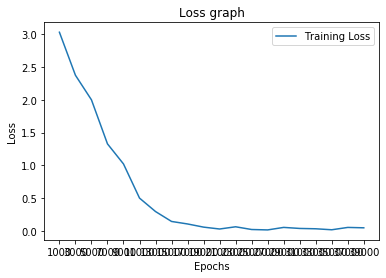

In [11]:
import matplotlib.pyplot as plt

iterations = np.arange(1000, 40001, 2000)
plt.plot(iterations, loss_plot, label = 'Training Loss')
plt.title('Loss graph')
plt.xlabel('Epochs')
plt.xticks(np.arange(1000, 40001, 2000))
plt.ylabel('Loss')
plt.legend()
plt.show()

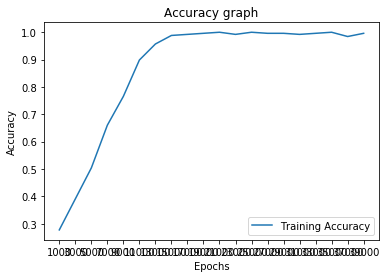

In [12]:
iterations = np.arange(1000, 40001, 2000)
plt.plot(iterations, accuracy_plot, label = 'Training Accuracy')
plt.title('Accuracy graph')
plt.xlabel('Epochs')
plt.xticks(np.arange(1000, 40001, 2000))
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Real time predictions

In [18]:
#User defined function for making predictions
def predict(index):
    
    '''
    Input - Number, which is treated as an index pointing to data in test set
    Returns - None

    Output - Predictions with display of the test Image  
    '''
    prediction = model(X_test[index].reshape(1, 3072), is_training = False)
    print('Actual Ground Truth is {}'.format(np.argmax(Y_test[index])))
    print('Prediction for test image is {}'.format(np.argmax(prediction)))
    plt.imshow(np.reshape(X_test[index].reshape(1, 3072), [32, 32, 3]))

Actual Ground Truth is 71
Prediction for test image is 87


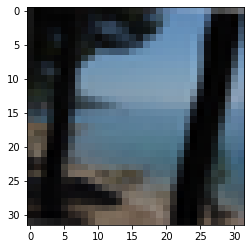

In [19]:
predict(10)

Actual Ground Truth is 4
Prediction for test image is 45


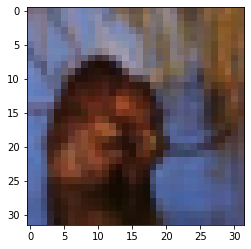

In [20]:
predict(50)

Actual Ground Truth is 50
Prediction for test image is 48


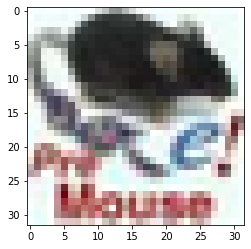

In [21]:
predict(1500)